<a href="https://colab.research.google.com/github/rchicangana/AnalisisDatosProyecto/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1  Introduccion

El análisis exploratorio de datos es una etapa fundamental en cualquier proyecto de Inteligencia Artificial y Ciencia de Datos, puesto que permite entender las características y patrones en los datos, así como identificar relaciones entre variables.

A continuación se presenta un estudio basado en datos de consumo de energía eléctrica horaria registrados en Cali, Colombia, junto con las temperaturas correspondientes a cada hora. El objetivo principal es explorar la relación entre estas dos variables y, posteriormente, aplicar diferentes modelos para realizar el pronósticos de corto plazo del demanda de energía.

# 2  Contexto

La demanda de energía eléctrica en una ciudad se ve inlfuenciada por muchos factores, como la temperatura, factores sociales, cronograma de produccion de grandes clientes, entre otros.

En regiones con climas variables, como es el caso de muchas ciudades Colombianas, la demanda es afectada por el uso intensivo de sistemas de refrigeración en épocas calurosas.

Los datos utilizados en este análisis incluyen mediciones horarias del consumo de energía y la temperatura registrada en la misma franja horaria, tipos de dia, mes y año. Lo que permite explorar la correlación entre estas variables.

Adicionalmente, se busca evaluar el desempeño de diferentes modelos como regresiones lineales, redes neuronales y modelos basados en árboles de decisión, para predecir el consumo de energía en un horizonte de corto plazo.

## 2.1  Descripción de los campos

- FECHA: Fecha en formato ISO de la lectura del consumo
- TEMPERATURA: Temperatura en grados Centigrados al momento de la toma del dato
- CONSUMO: Variable objetvio medido en MVA

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import holidays

df = pd.read_csv('datasetEmcali.csv')
print(df.head())
print(df.info())

            FECHA  TEMPERATURA  CONSUMO
0  12/1/2017 0:00         27.9    409.0
1  12/1/2017 1:00         29.0    387.0
2  12/1/2017 2:00         29.1    378.0
3  12/1/2017 3:00         28.2    370.0
4  12/1/2017 4:00         26.7    364.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29808 entries, 0 to 29807
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        29520 non-null  object 
 1   TEMPERATURA  29328 non-null  float64
 2   CONSUMO      29520 non-null  float64
dtypes: float64(2), object(1)
memory usage: 698.8+ KB
None


# 3  Análisis exploratorio


## 3.1  Análisis de estructura


Se realiza un analisis de la forma del dataset, se relacionan tipos de datos, estadisticas descriptivas y valores nulos.

Se adicionan columnas, basadas en la fecha, con la hipotesis que esto permitira al modelo entender e interpretar mejor los datos.

In [17]:
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['CONSUMO'] = pd.to_numeric(df['CONSUMO'], errors='coerce')
df['TEMPERATURA'] = pd.to_numeric(df['TEMPERATURA'], errors='coerce')

df = df.dropna(subset=['FECHA']) # Elimina las filas donde 'FECHA' es NaN
                                 # final del data set, no tienen informacion

def es_festivo_colombia(fecha):
    """Verifica si una fecha es festivo en Colombia."""
    co_holidays = holidays.CO(years=fecha.year)
    return fecha in co_holidays
df['Es_Festivo'] = df['FECHA'].apply(es_festivo_colombia)

# Extract numerical features from 'FECHA'
df['Year'] = df['FECHA'].dt.year
df['Month'] = df['FECHA'].dt.month
df['Day'] = df['FECHA'].dt.day
df['Hour'] = df['FECHA'].dt.hour
df['Dayofweek'] = df['FECHA'].dt.dayofweek
df['Dayofyear'] = df['FECHA'].dt.dayofyear
df['Weekofyear'] = df['FECHA'].dt.isocalendar().week
df['Is_month_end'] = df['FECHA'].dt.is_month_end
df['Is_month_start'] = df['FECHA'].dt.is_month_start
df['Is_quarter_end'] = df['FECHA'].dt.is_quarter_end
df['Is_quarter_start'] = df['FECHA'].dt.is_quarter_start
df['Is_year_end'] = df['FECHA'].dt.is_year_end
df['Is_year_start'] = df['FECHA'].dt.is_year_start

print("Forma de lo datos:", df.shape)
print("\nTipo de datos por columnas:\n\n", df.dtypes)
print("\nEstadisticas descriptivas:\n\n", df.describe())
print("\nValores Faltantes:\n\n", df.isnull().sum())
print("\nValores Faltantes(%):\n\n", (df.isnull().sum() / len(df)) * 100)

Forma de lo datos: (29520, 17)

Tipo de datos por columnas:

 FECHA               datetime64[ns]
TEMPERATURA                float64
CONSUMO                    float64
Es_Festivo                    bool
Year                         int32
Month                        int32
Day                          int32
Hour                         int32
Dayofweek                    int32
Dayofyear                    int32
Weekofyear                  UInt32
Is_month_end                  bool
Is_month_start                bool
Is_quarter_end                bool
Is_quarter_start              bool
Is_year_end                   bool
Is_year_start                 bool
dtype: object

Estadisticas descriptivas:

                      FECHA   TEMPERATURA       CONSUMO          Year  \
count                29520  29328.000000  29520.000000  29520.000000   
mean   2019-08-07 23:30:00     24.130615    455.574139   2019.117886   
min    2017-12-01 00:00:00     16.100000    227.000000   2017.000000   
25%    2018

## 3.2  Análisis de variables numericas


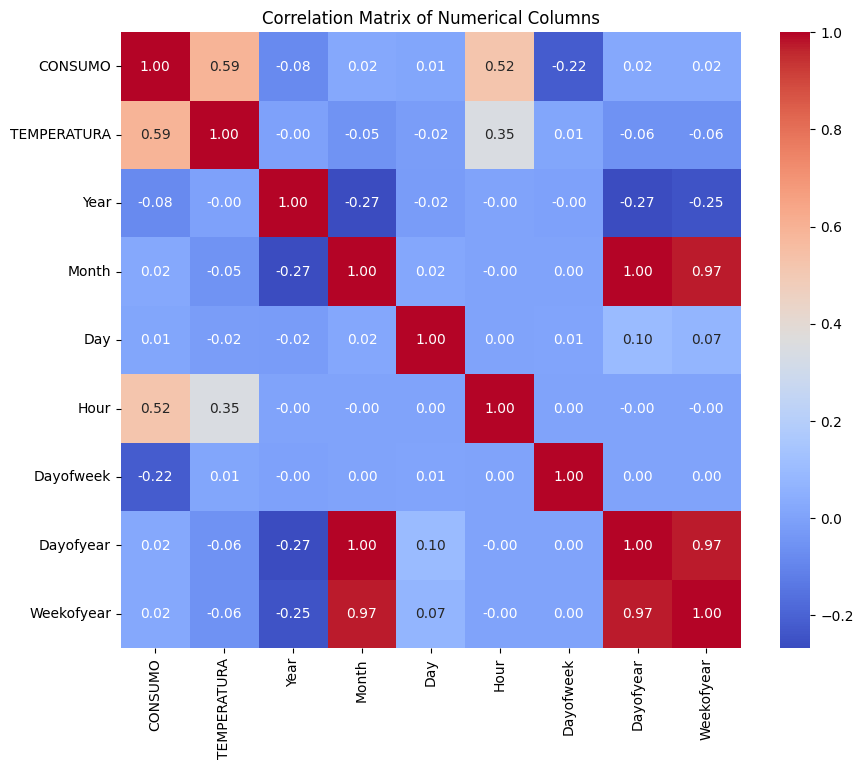

In [18]:
numerical_columns = ['CONSUMO', 'TEMPERATURA', 'Year', 'Month', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Weekofyear']
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()



## 3.3  Análisis de variables Categoricas


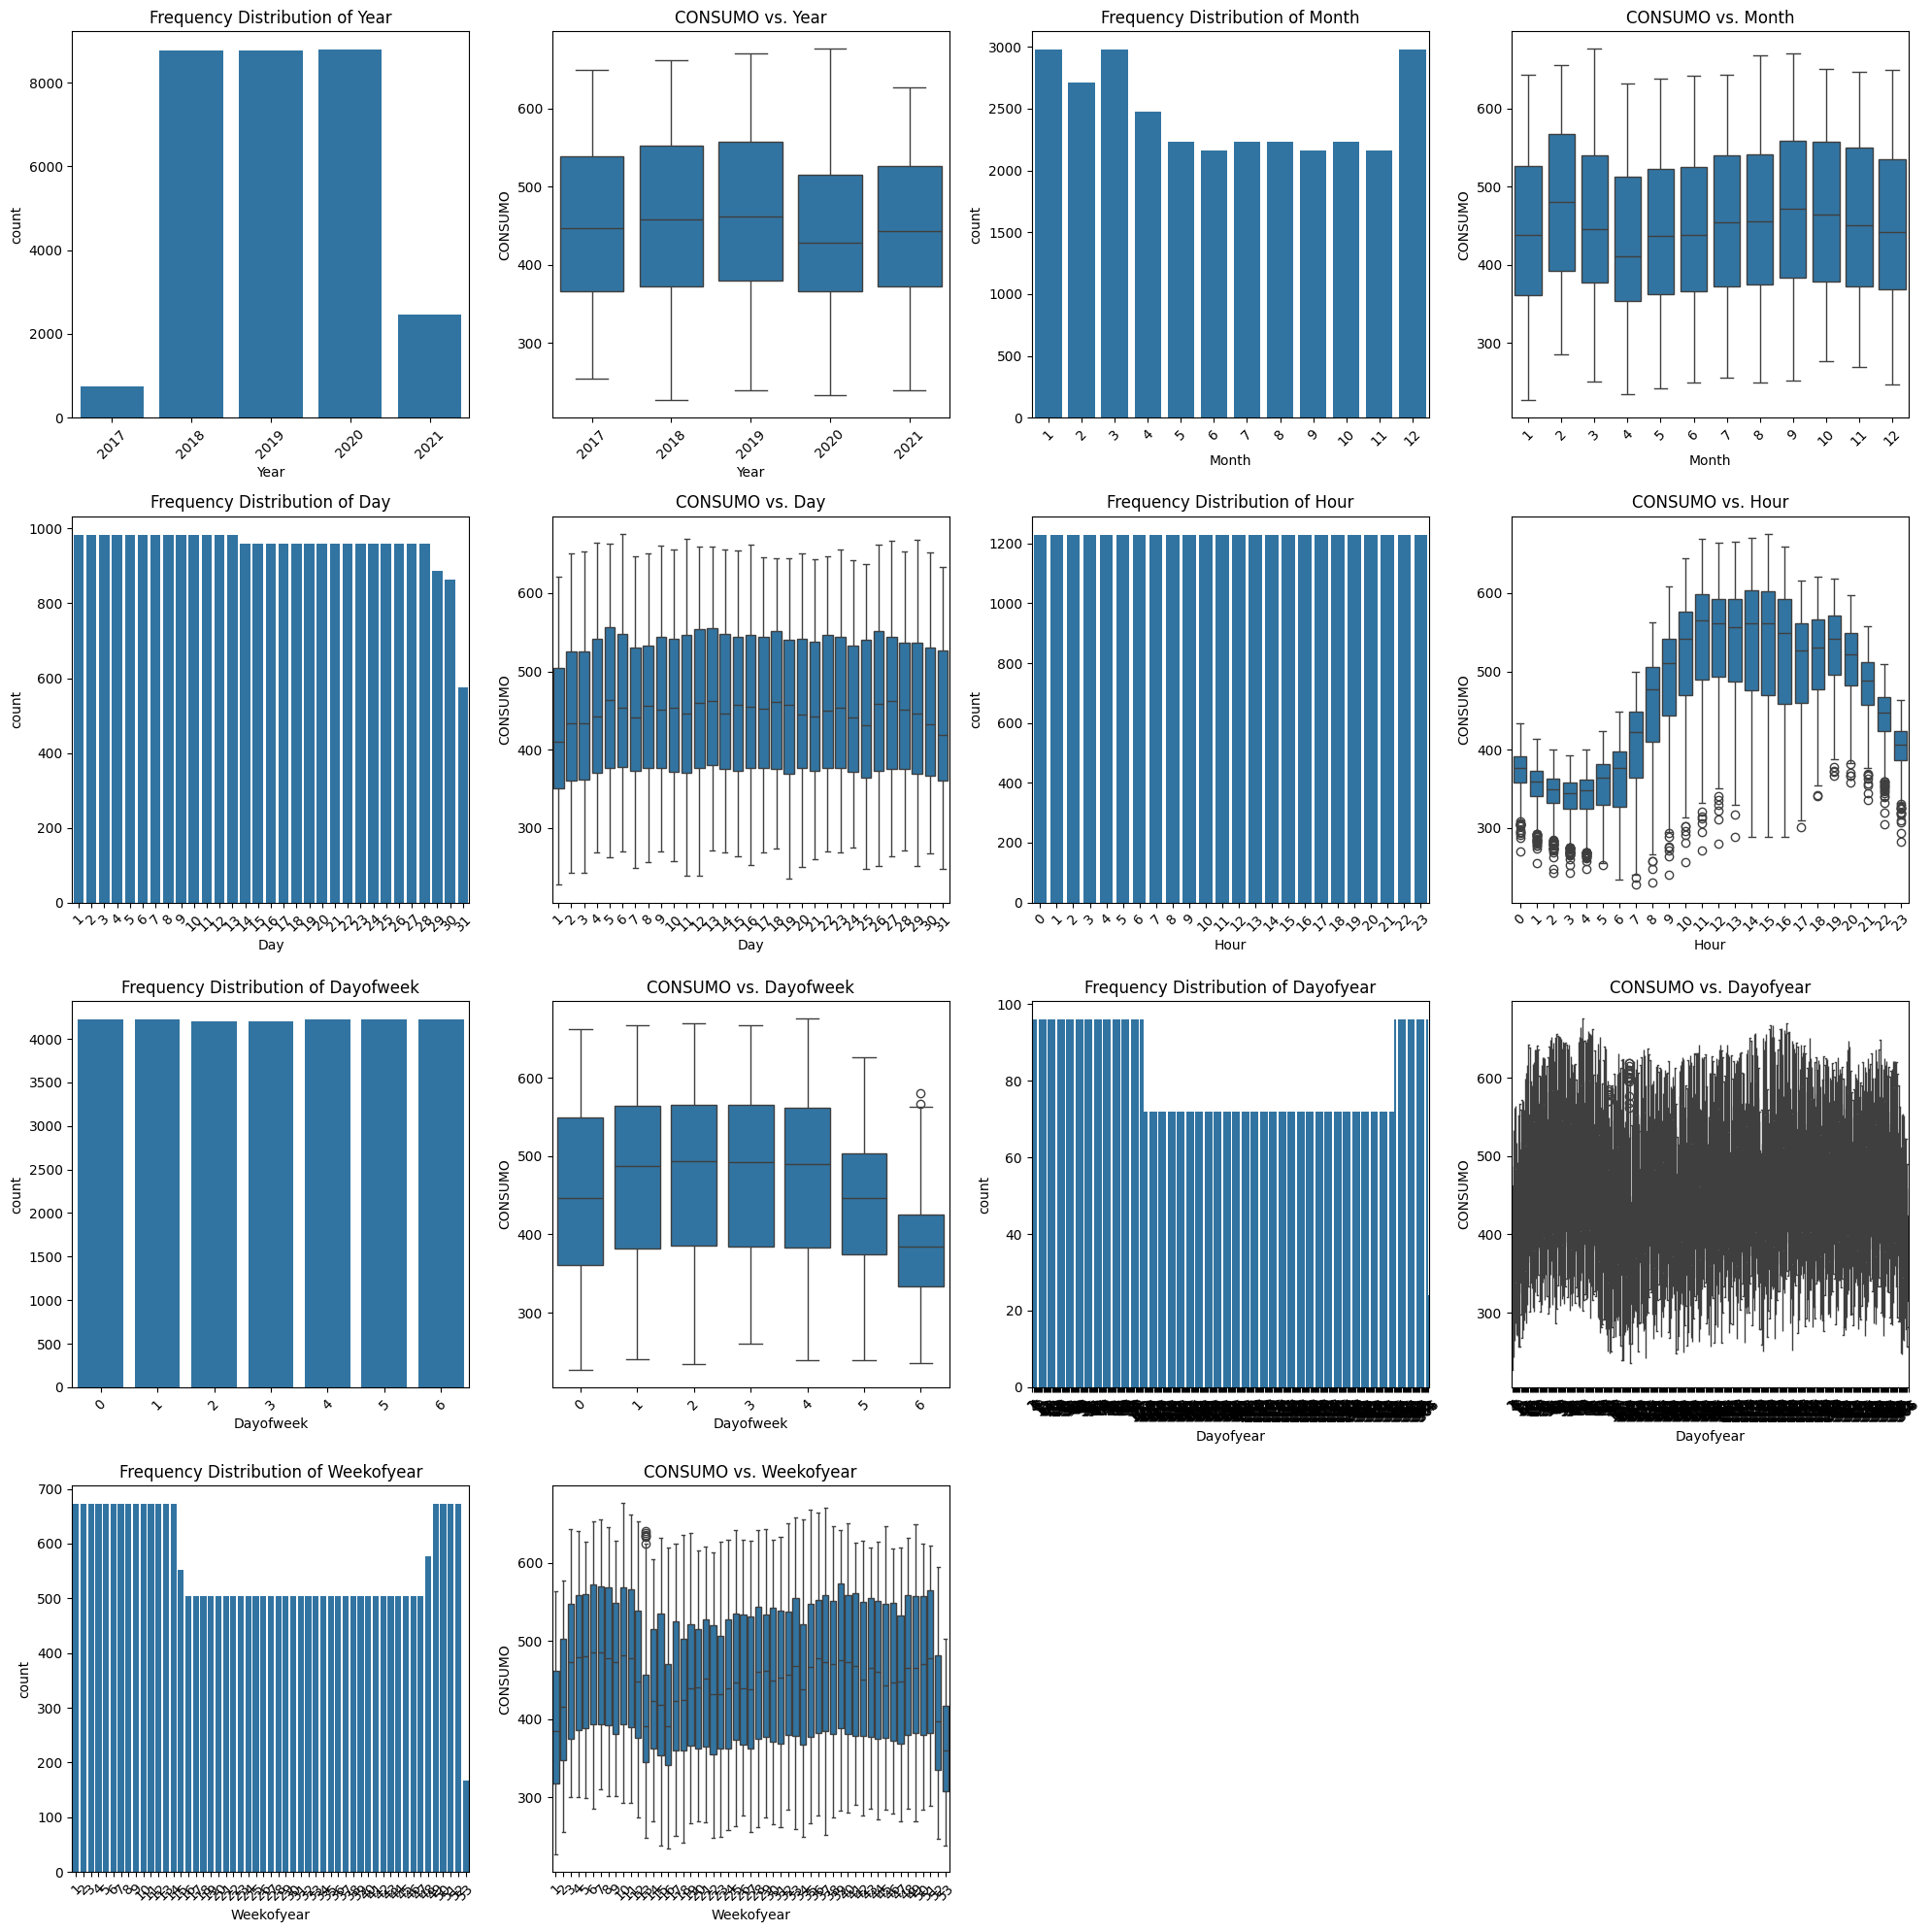

In [19]:
# Assuming 'df' is your DataFrame and 'categorical_cols' is defined
categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Weekofyear']

# Determine the number of rows needed for the subplots
num_cols = 4  # 4 columns per row
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.

# Create subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    # Countplot
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    axes[i * 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    # Boxplot
    sns.boxplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')
    axes[i * 2 + 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

# Remove any unused subplots
for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

Los años 2020 y 2021 presentaron un fenomeno social el cual no es posible modelar en este espacio. Las restricciones a la movilidad en la pandemia y el paro nacional, impactaron directamente el consumo de eneriga en la ciudad de Cali.

Se concidera prudente, sacar del estudio estos dos años.

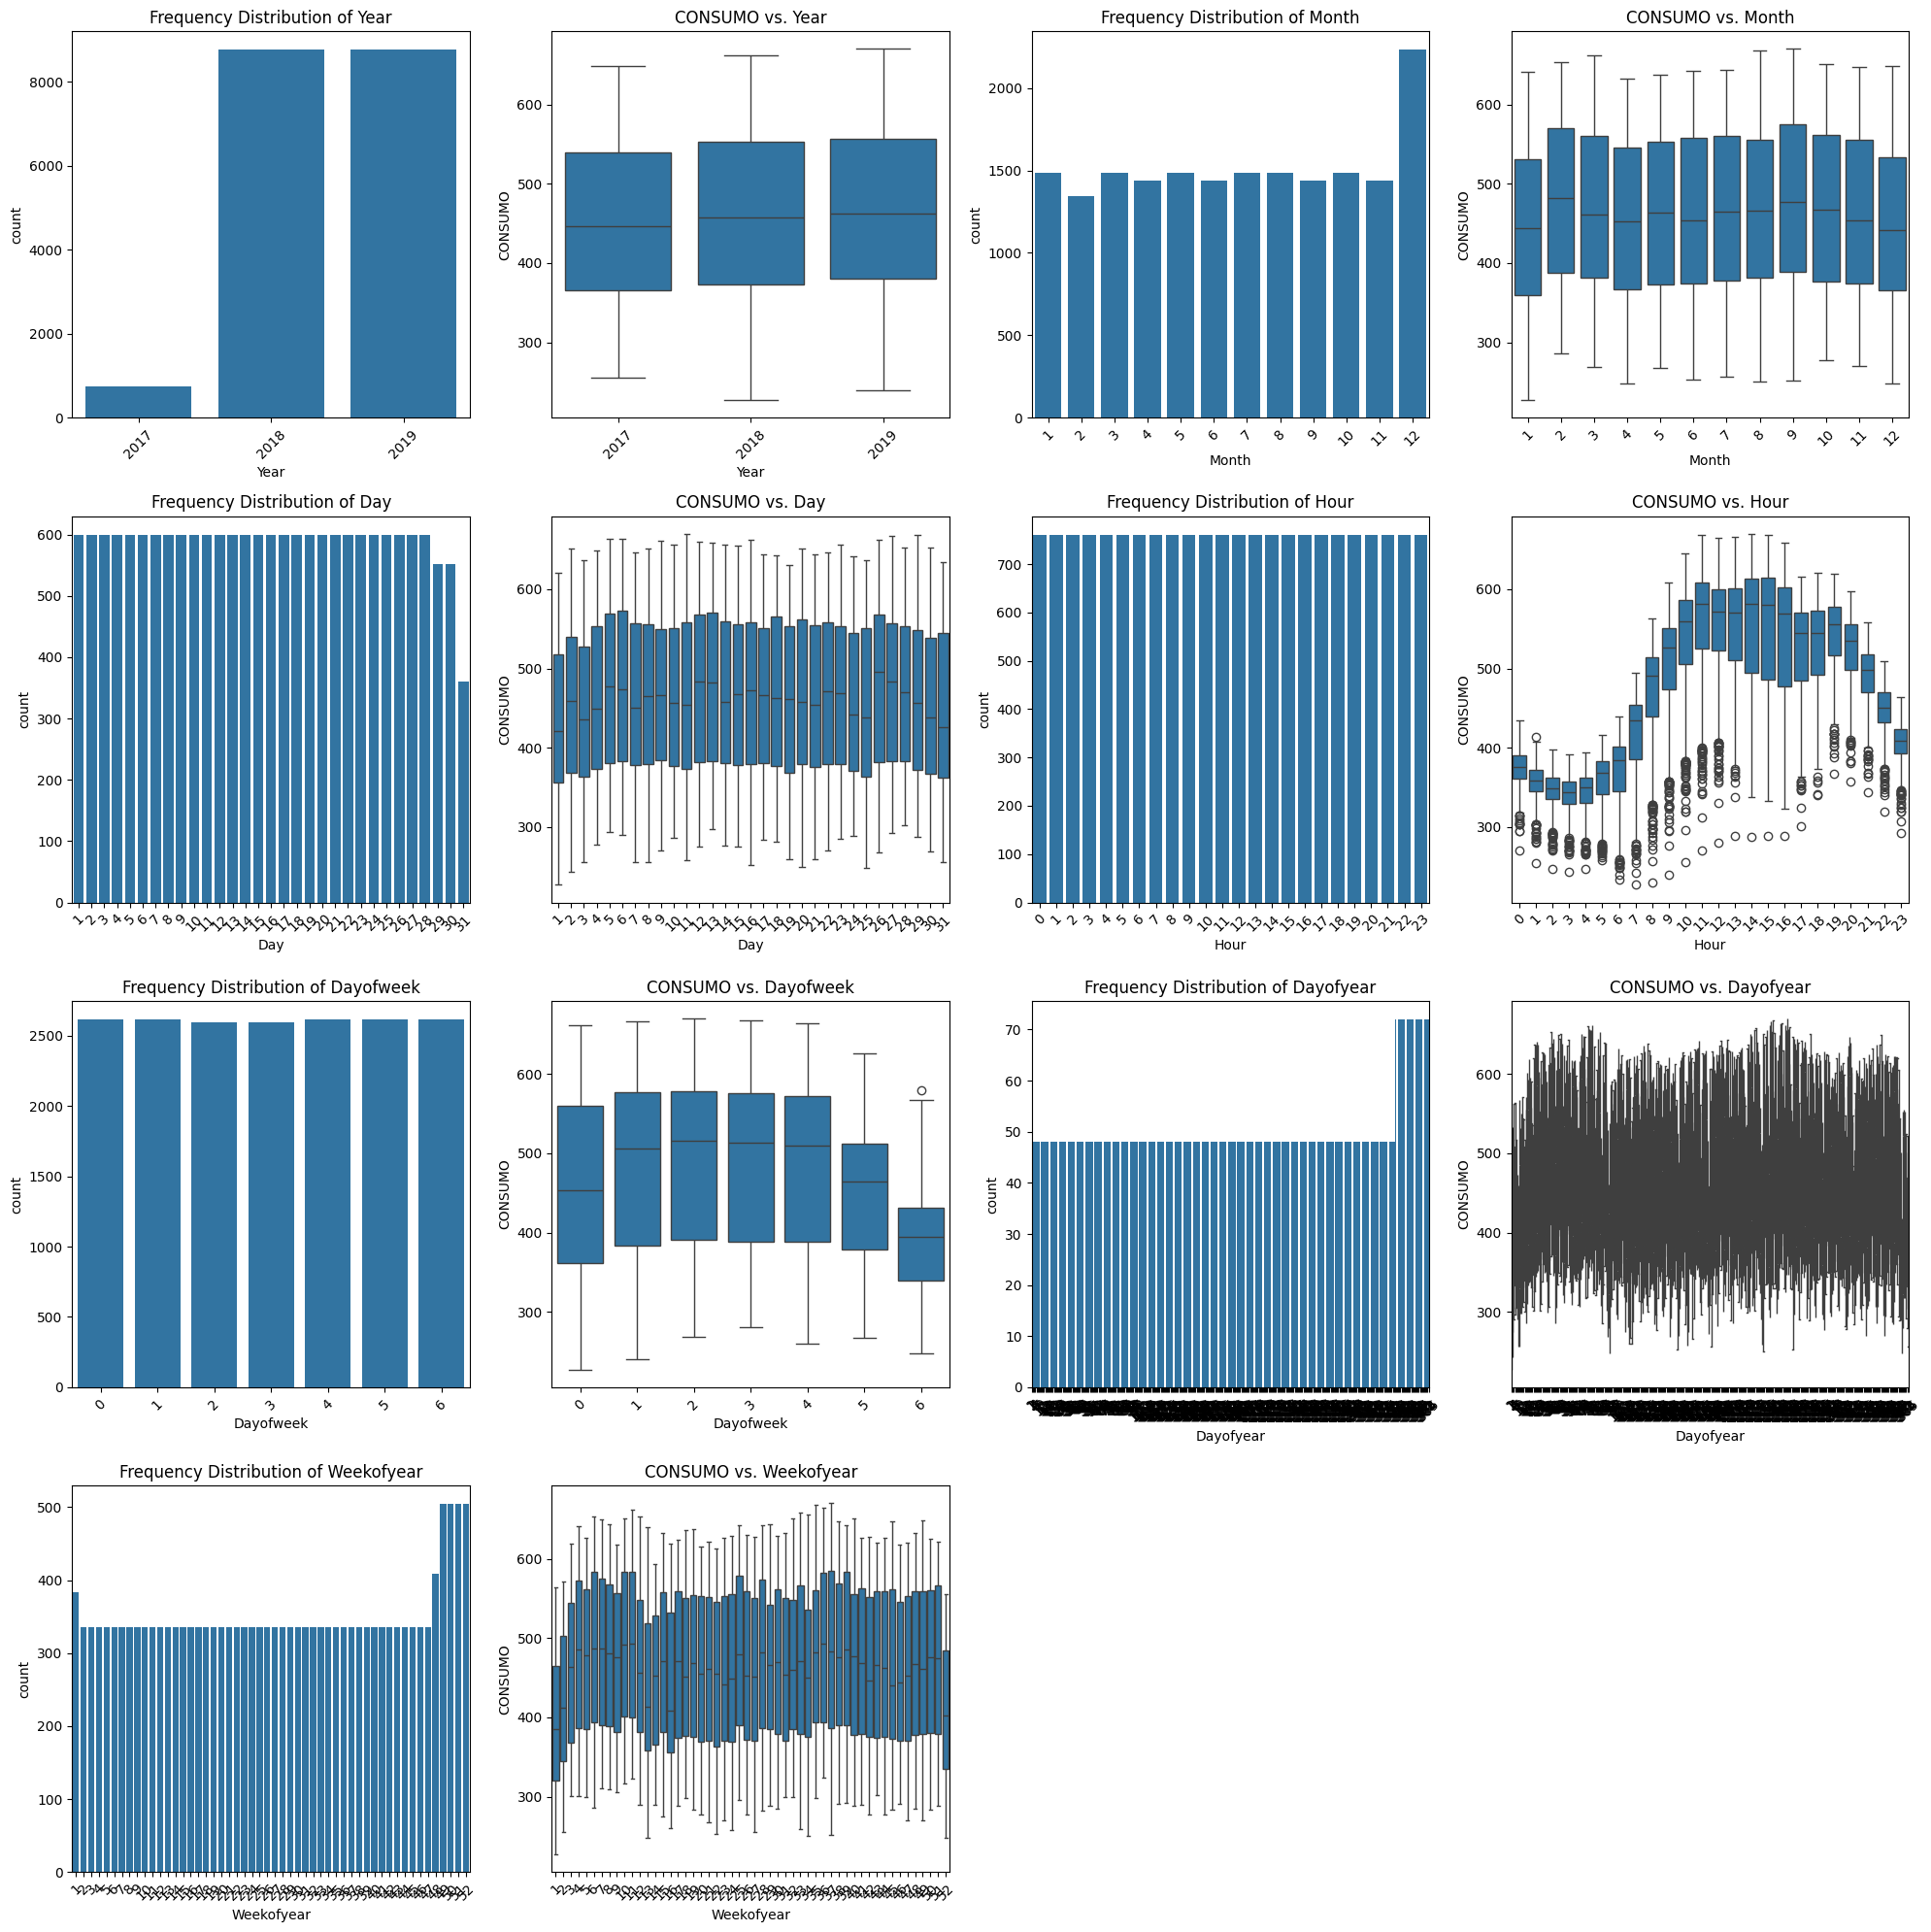

In [20]:
df = df.drop(df[(df['Year'] == 2020) | (df['Year'] == 2021)].index)
df = df.reset_index(drop=True)
categorical_cols = ['Year', 'Month', 'Day', 'Hour', 'Dayofweek', 'Dayofyear', 'Weekofyear']
num_cols = 4  # 4 columns per row
num_rows = (len(categorical_cols) * 2 + num_cols - 1) // num_cols # Calculate the rows needed.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i * 2])
    axes[i * 2].set_title(f'Frequency Distribution of {col}')
    axes[i * 2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    sns.boxplot(x=col, y='CONSUMO', data=df, ax=axes[i * 2 + 1])
    axes[i * 2 + 1].set_title(f'CONSUMO vs. {col}')
    axes[i * 2 + 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed
for j in range(len(categorical_cols) * 2, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

## 3.4  Análisis de variables continuas

### 3.4.1  Analisis de outliers


### 3.4.2  Conclusiones Outliers


# 4  Limpieza de datos


## 4.1  Division de datasets


## 4.2  Estandarización


## 4.3  Imputación


# 5  Feature Engineering


## 5.1  Dummificar variables


## 5.2  PCA


## 5.3  LDA


## 5.4  Clustering


# 6 Data Pipeline


# 7  Modelamiento